In [9]:
import numpy as np #We import all our libraries
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from scipy import optimize # for fits
import sys
from sympy import latex, symbols, sin, cos, pi, simplify, lambdify, Matrix

%matplotlib inline
rng = np.random.RandomState(0)
from IPython.display import display, Math
import torch
import torch.autograd.functional as functional

In [10]:
def fgrad(inputs): #This function allow us to create the hessian by calling it later.
    return torch.autograd.functional.jacobian(metric_tensor,inputs, create_graph=True)
def christoffelderiv(coord1, coord2, deriv, alpha, beta): #It's the part of the Riemann tensor with the derivative of the Christoffel.
    christoffelderiv = 0.5*((jacobinv_l[alpha][beta][deriv] * (jacob_l[alpha][coord1][coord2] + jacob_l[alpha][coord2][coord1] - jacob_l[coord1][coord2][alpha]))\
                                    + g_inv_l[alpha][beta] * (hessian_l[alpha][coord1][coord2][deriv] + hessian_l[alpha][coord2][coord1][deriv] - hessian_l[coord1][coord2][alpha][deriv]))
    return christoffelderiv 
def christoffelproduct_liste(coord1, coord2, coord3): #This function gives us the product of two christoffels.
        christoffelproduct = christoffel_l[beta][coord1][eta]*christoffel_l[eta][coord2][coord3]
        return christoffelproduct
epsilon= sys.float_info.epsilon

## Metric tensor: 2D unit sphere

Coordinates $x^\alpha = (\theta, \phi)$.

\begin{equation}
g_{\mu\nu} = 
\begin{pmatrix}
1 & 0 \\
0 & \sin^2 \theta \\
\end{pmatrix}
\end{equation}

In [11]:
#We define a metric tensor. 
dim=2 #Tell the dimension.

def metric_tensor(coordinate,*arg): #This function create the metric tensor, we need to put in a fonction to be able to
                                    #calculate its derivatives with our jacobian later.
    """
    Here, we have as arg for our function : 
    coordinates : (theta, phi) of a point 
    """
    theta=coordinate[0] 
    phi=coordinate[1]
    tensor = torch.zeros(dim,dim)
    tensor[0,0] = 1
    tensor[1,1] = torch.pow(torch.sin(theta),2)
    return tensor

def inverse(coordinate, *arg): #Gives us the inverse of the metric_tensor.
    theta=coordinate[0]
    phi=coordinate[1]
    tensor = torch.zeros(dim,dim)
    tensor[0,0] = 1
    tensor[1,1] = torch.pow(torch.sin(theta),2)
    tensor = torch.inverse(tensor)
    return tensor

In [12]:
#Let's set the initial coordinate to start with.  
coord = torch.tensor([0.5,3.],requires_grad=True)
print("theta,phi coordinates: ",coord.data)

theta,phi coordinates:  tensor([0.5000, 3.0000])


## Metric tensor: 4D flat space, spherical coordinates

Coordinates $x^\alpha = (ct, R, \theta, \phi)$.

\begin{equation}
g_{\mu\nu} = 
\begin{pmatrix}
1 & 0 & 0 & 0  \\
0 & -1 & 0 & 0 \\
0 & 0 & -R^2 & 0 \\
0 & 0 & 0 & -R^2 \sin^2 \theta \\
\end{pmatrix}
\end{equation}

In [18]:
#We define a metric tensor. 
dim=4 #Tell the dimension.

def metric_tensor(coordinate,*arg): 
                                    #This function create the metric tensor, we need to put in a fonction to be able to
                                    #calculate its derivatives with our jacobian later.
    """
    Args: 
        coordinates (ct,r,theta,phi) of a point
        arg: not used
    """
    t=coordinate[0] # c=1
    r=coordinate[1]
    theta=coordinate[2]
    phi=coordinate[3]
    tensor = torch.zeros(dim,dim)
    tensor[0,0] = 1
    tensor[1,1] = -1
    tensor[2,2] = -1 * torch.pow(r,2)
    tensor[3,3] = -1 * torch.pow(r*torch.sin(theta),2)
    return tensor

def inverse(coordinate, *arg): #And the inverse of the metric tensor. 
    tensor = metric_tensor(coordinate, *arg)
    tensor = torch.inverse(tensor)
    return tensor

In [19]:
#Let's set the initial coordinate to start with.  
coord = torch.tensor([1., 5., 10., 15.],requires_grad=True)

## Metric tensor: Schwarzschid metric

Coordinates $x^\alpha = (ct, R, \theta, \phi)$.

$$g_{\mu\nu} = 
\begin{pmatrix}
1 - \frac{2GM}{Rc^2} & 0 & 0 & 0 \\
0 & -\left(1 - \frac{2GM}{Rc^2}\right)^{-1} & 0 & 0 \\
0 & 0 & -R^2 & 0 \\
0 & 0 & 0 & -R^2 \sin^2 \theta \\
\end{pmatrix}
= 
\begin{pmatrix}
1 - \frac{R_s}{R} & 0 & 0 & 0 \\
0 & -\left(1 - \frac{R_s}{R}\right)^{-1} & 0 & 0 \\
0 & 0 & -R^2 & 0 \\
0 & 0 & 0 & -R^2 \sin^2 \theta \\
\end{pmatrix}
$$

With $R_s = \frac{2 G M}{c^2}$, Schwarzschild radius.

In [27]:
#We define a metric tensor. 
dim=4 #Tell the dimension.
Rs = 1 #Here, we have arguments. Rs is the one argument of this metric tensor.
def metric_tensor(coordinate,*arg):#This function create the metric tensor, we need to put in a fonction to be able to
                                    #calculate its derivatives with our jacobian later.
    """
    Args: 
        coordinates (ct,r,theta,phi) of a point
        arg[0]: Rs, Schwarzschid radius
    """
    t=coordinate[0] # c=1
    r=coordinate[1]
    theta=coordinate[2]
    phi=coordinate[3]
    #if (len(arg)>0):
    #    Rs = arg[0] # Schwarzschid radius
    tensor = torch.zeros(dim,dim)
    tensor[0,0] = 1 - Rs/r
    tensor[1,1] = -1 * torch.pow(1 - Rs/r,-1)
    tensor[2,2] = -1 * torch.pow(r,2)
    tensor[3,3] = -1 * torch.pow(r*torch.sin(theta),2)
    return tensor

def inverse(coordinate, *arg):
    tensor = metric_tensor(coordinate, *arg)
    tensor = torch.inverse(tensor)
    return tensor

In [37]:
coord = torch.tensor([1000, 1000., 500., 150.],requires_grad=True)
print("t,r,theta,phi coordinates: ",coord.data)

t,r,theta,phi coordinates:  tensor([1000., 1000.,  500.,  150.])


In [38]:
#here, we calculate all that is needed to do the further calculations such as the Christofell and the jacobian.

g = metric_tensor(coord)
g_l = g.tolist() #We also convert it into a list.
g_inv = torch.inverse(g)
g_inv_l = g_inv.tolist()
#We do all the preliminary calculations : 
jacob = functional.jacobian(metric_tensor,(coord)) #We take the jacobian of our metric tensor at the desirated coordinate
jacob_l = jacob.tolist()
jacobinv = functional.jacobian(inverse, (coord)) #And we take alsothe jacobian of the inverse metric tensor as we will need ti.
jacobinv_l = jacobinv.tolist()
hessian = torch.autograd.functional.jacobian(fgrad,(coord), create_graph=True) #fgrad here is the jacobian put in a function. 
#By doing the jacobian of the jacobian of the metric tensor at a given coordinate, one gets the hessian at those coordinates.
hessian_l = hessian.tolist()



In [39]:
#We write down the coordinates
distance = int(input('What distance do you want from the beginning? \n distance = '))
pas = 1 #The step done between each calculations. 
n = distance/pas
n = int(n)
coord_l = coord.tolist() #We convert it to list to better manipulate it. 
liste=[]
for i in range(dim):
    x = np.arange(coord_l[i], coord_l[i]+distance+pas, pas)
    x_l = x.tolist()
    liste.append(x_l)
listetensor = torch.tensor(liste)

#We write down our coordinates. 
f = open("coordinates.txt", "w")
for i in range(dim):
    for j in range(n+1):
        x = str(liste[i][j])
        f.write(x + ',')
    f.write('\n')
f.close() 

f = open("coordinates.txt", "r")
read_list = []
i = 0
for line in f:
    read_list_str = line.split(',')
    read_list_str.pop()
    read_list_scalar = [float(x) for x in read_list_str]
    read_list.append(read_list_scalar)
    print("x_",i,"=", read_list_scalar)
    i=+1
f.close() 
print(read_list)


What distance do you want from the beginning? 
 distance = 0
x_ 0 = [1000.0]
x_ 1 = [1000.0]
x_ 1 = [500.0]
x_ 1 = [150.0]
[[1000.0], [1000.0], [500.0], [150.0]]


In [44]:
void = np.zeros(dim)
actual_list = void.tolist()
plot_list = []
scalarlist = []
christo_data = open("christo_data.txt", "w") #We create the files for data.
riemann_data = open("riemann_data.txt", "w")
ricci_data = open("ricci_data.txt", "w")
scalarcurvature_data = open("scalarcurvature_data.txt", "w")
for i in range(dim+1):
    plot_list.append([])
print(plot_list)
if dim==1:
    for i in range(n+1):
            actual_list[0] = read_list[0][i]
            plot_list[0].append(actual_list[0])   
elif dim==2:
    for i in range(n+1):
        for j in range(n+1): 
            actual_list = void.tolist() #Here, we read the current data.
            actual_list[0] = read_list[0][i]
            actual_list[1] = read_list[1][j]
            plot_list[0].append(actual_list[0])
            plot_list[1].append(actual_list[1])
            coord_ten = torch.tensor(actual_list)
            g = metric_tensor(coord_ten) #Such as the metric tensor
            print(g)
            g_l = g.tolist() 
            #print(g_l)
            g_inv = torch.inverse(g)#Such as the inverse metric tensor
            g_inv_l = g_inv.tolist()
            #We do all the preliminary calculations : 
            jacob = functional.jacobian(metric_tensor,(coord_ten)) #We take the jacobian of our metric tensor at the desirated coordinate
            jacob_l = jacob.tolist() 
            jacobinv = functional.jacobian(inverse, (coord_ten))
            jacobinv_l = jacobinv.tolist()
            hessian = torch.autograd.functional.jacobian(fgrad,(coord_ten), create_graph=True)
            hessian_l = hessian.tolist()
            #Christoffel
            christoffel = torch.zeros(dim,dim,dim)
            for beta in range(0,dim):
                for mu in range(0,dim):
                    for nu in range(0,dim):
                        cricri = 0
                        for alpha in range(0,dim): #Here the loop are done in respect the einstein summation convention.
                            cricri += 0.5 * g_inv_l[alpha][beta] * (jacob_l[alpha][mu][nu] + jacob_l[alpha][nu][mu] - jacob_l[mu][nu][alpha])
                            christoffel[beta,mu,nu] = cricri
            
                christoffel_l = christoffel.tolist() #After having written down a list, we need to write down the data in our file.
                for beta in range(0,dim):
                    for mu in range(0,dim):
                        for nu in range(0,dim):
                            x = str(christoffel_l[beta][mu][nu])
                            christo_data.write(x + ',')#We follow a simple 
                            christo_data.write('_')
                    christo_data.write(':')
                christo_data.write('\n')
            #We follow a simple indice code to separate our data :  
                    #coord : "/n"                               
                        #beta : ":"
                            #epsilon : "/"
                                # mu : "_"
                                    # nu : ","
                #Riemann
            riemann = torch.zeros(dim,dim,dim,dim)
            riemann_l = riemann.tolist()
            for beta in range(0,dim):
                for epsilon in range(0,dim):
                    for mu in range(0,dim):
                        for nu in range(0,dim):
                            riemannscalar = 0
                            for alpha in range(0,dim): 
                                #Here as you can see, the riemann tensor is divided in the addition of those two functions
                                riemannscalar += christoffelderiv(mu, epsilon, nu, alpha, beta)-christoffelderiv(mu, nu, epsilon, alpha, beta)
                                #First the christoffel derivatives
                            for eta in range(0,dim):
                                #Then the christoffelproduct.
                                riemannscalar += christoffelproduct_liste(nu, mu, epsilon) - christoffelproduct_liste(epsilon, mu, nu) 
                            riemann_l[beta][mu][nu][epsilon] = riemannscalar
            #We write down the data for the riemann tensor.
            for beta in range(0,dim):
                for epsilon in range(0,dim):
                    for mu in range(0,dim):
                        for nu in range(0,dim):
                            x = str(riemann_l[beta][mu][nu][epsilon])
                            riemann_data.write(x + ',')
                        riemann_data.write('_')
                    riemann_data.write('/')
                riemann_data.write(':')
            riemann_data.write('\n')
            #Ricci 
            ricci = torch.zeros(dim,dim)
            ricci_l = ricci.tolist()
            for mu in range(0, dim):
                for nu in range(0, dim):
                    riccisca = 0
                    for alpha in range(0, dim):
                        riccisca += riemann_l[alpha][mu][alpha][nu]
                        ricci_l[mu][nu]= riccisca
            #We write down the data for the ricci tensor.
            for mu in range(0,dim):
                for nu in range(0,dim):
                    x = str(ricci_l[mu][nu])
                    ricci_data.write(x + ',')
                ricci_data.write('_')
            ricci_data.write('\n')
    
            #Scalar curvature
            scalarcurvature = 0
            for mu in range(dim):
                for nu in range(dim):
                    scalarcurvature += g_inv_l[mu][nu]*ricci_l[mu][nu]  
            x = str(scalarcurvature)
            scalarlist.append(scalarcurvature)
            scalarcurvature_data.write(x + '\n')
            actual_list.pop()
            actual_list.pop()
elif dim==3:
    for i in range(n+1):
        for j in range(n+1):
            for h in range(n+1):
                actual_list = void.tolist()
                actual_list[0] = read_list[0][i]#Here, we read the current data.
                actual_list[1] = read_list[1][j]
                actual_list[2] = read_list[2][h]
                plot_list[0].append(actual_list[0])
                plot_list[1].append(actual_list[1])
                plot_list[2].append(actual_list[2])
                plot_list[0].append(actual_list[0])
                plot_list[1].append(actual_list[1])
                coord_ten = torch.tensor(actual_list)
                g = metric_tensor(coord_ten) #Such as the metric tensor
                g_l = g.tolist() 
                #print(g_l)
                g_inv = torch.inverse(g)#Such as the inverse metric tensor
                g_inv_l = g_inv.tolist()
                #We do all the preliminary calculations : 
                jacob = functional.jacobian(metric_tensor,(coord_ten)) #We take the jacobian of our metric tensor at the desirated coordinate
                jacob_l = jacob.tolist() 
                jacobinv = functional.jacobian(inverse, (coord_ten))
                jacobinv_l = jacobinv.tolist()
                hessian = torch.autograd.functional.jacobian(fgrad,(coord_ten), create_graph=True)
                hessian_l = hessian.tolist()
                #Christoffel
                christoffel = torch.zeros(dim,dim,dim)
                for beta in range(0,dim):
                    for mu in range(0,dim):
                        for nu in range(0,dim):
                            cricri = 0
                            for alpha in range(0,dim): #Here the loop are done in respect the einstein summation convention.
                                cricri += 0.5 * g_inv_l[alpha][beta] * (jacob_l[alpha][mu][nu] + jacob_l[alpha][nu][mu] - jacob_l[mu][nu][alpha])
                                christoffel[beta,mu,nu] = cricri
            
                    christoffel_l = christoffel.tolist() #After having written down a list, we need to write down the data in our file.
                    for beta in range(0,dim):
                        for mu in range(0,dim):
                            for nu in range(0,dim):
                                x = str(christoffel_l[beta][mu][nu])
                                christo_data.write(x + ',')#We follow a simple 
                                christo_data.write('_')
                        christo_data.write(':')
                    christo_data.write('\n')
            #We follow a simple indice code to separate our data :  
                    #coord : "/n"                               
                        #beta : ":"
                            #epsilon : "/"
                                # mu : "_"
                                    # nu : ","
                #Riemann
                riemann = torch.zeros(dim,dim,dim,dim)
                riemann_l = riemann.tolist()
                for beta in range(0,dim):
                    for epsilon in range(0,dim):
                        for mu in range(0,dim):
                            for nu in range(0,dim):
                                riemannscalar = 0
                                for alpha in range(0,dim): 
                                #Here as you can see, the riemann tensor is divided in the addition of those two functions
                                    riemannscalar += christoffelderiv(mu, epsilon, nu, alpha, beta)-christoffelderiv(mu, nu, epsilon, alpha, beta)
                                #First the christoffel derivatives
                                for eta in range(0,dim):
                                #Then the christoffelproduct.
                                    riemannscalar += christoffelproduct_liste(nu, mu, epsilon) - christoffelproduct_liste(epsilon, mu, nu) 
                                riemann_l[beta][mu][nu][epsilon] = riemannscalar
            #We write down the data for the riemann tensor.
                for beta in range(0,dim):
                    for epsilon in range(0,dim):
                        for mu in range(0,dim):
                            for nu in range(0,dim):
                                x = str(riemann_l[beta][mu][nu][epsilon])
                                riemann_data.write(x + ',')
                            riemann_data.write('_')
                        riemann_data.write('/')
                    riemann_data.write(':')
                riemann_data.write('\n')
            #Ricci 
                ricci = torch.zeros(dim,dim)
                ricci_l = ricci.tolist()
                for mu in range(0, dim):
                    for nu in range(0, dim):
                        riccisca = 0
                        for alpha in range(0, dim):
                            riccisca += riemann_l[alpha][mu][alpha][nu]
                            ricci_l[mu][nu]= riccisca
            #We write down the data for the ricci tensor.
                for mu in range(0,dim):
                    for nu in range(0,dim):
                        x = str(ricci_l[mu][nu])
                        ricci_data.write(x + ',')
                    ricci_data.write('_')
                ricci_data.write('\n')
    
            #Scalar curvature
                scalarcurvature = 0
                for mu in range(dim):
                    for nu in range(dim):
                        scalarcurvature += g_inv_l[mu][nu]*ricci_l[mu][nu]  
                x = str(scalarcurvature)
                scalarlist.append(scalarcurvature)
                scalarcurvature_data.write(x + '\n')
elif dim==4:
    for i in range(n+1):
        for j in range(n+1):
            for h in range(n+1): 
                for l in range(n+1):
                    actual_list = void.tolist()
                    actual_list[0] = read_list[0][i] #Here, we read the current data.
                    actual_list[1] = read_list[1][j]
                    actual_list[2] = read_list[2][h]
                    actual_list[3] = read_list[3][l]
                    plot_list[0].append(actual_list[0]) #We put the coordinate in a list to read it later for our plot.
                    plot_list[1].append(actual_list[1])
                    plot_list[2].append(actual_list[2])
                    plot_list[3].append(actual_list[3])
                    coord_ten = torch.tensor(actual_list)
                    g = metric_tensor(coord_ten) #Such as the metric tensor
                    g_l = g.tolist()
                    #print(g_l)
                    g_inv = torch.inverse(g)#Such as the inverse metric tensor
                    g_inv_l = g_inv.tolist()
                    #We do all the preliminary calculations : 
                    jacob = functional.jacobian(metric_tensor,(coord_ten)) #We take the jacobian of our metric tensor at the desirated coordinate
                    jacob_l = jacob.tolist() 
                    jacobinv = functional.jacobian(inverse, (coord_ten))
                    jacobinv_l = jacobinv.tolist()
                    hessian = torch.autograd.functional.jacobian(fgrad,(coord_ten), create_graph=True)
                    hessian_l = hessian.tolist()
                    #Christoffel
                    christoffel = torch.zeros(dim,dim,dim)
                    for beta in range(0,dim):
                        for mu in range(0,dim):
                            for nu in range(0,dim):
                                cricri = 0
                                for alpha in range(0,dim): #Here the loop are done in respect the einstein summation convention.
                                    cricri += 0.5 * g_inv_l[alpha][beta] * (jacob_l[alpha][mu][nu] + jacob_l[alpha][nu][mu] - jacob_l[mu][nu][alpha])
                                    christoffel[beta,mu,nu] = cricri

                        christoffel_l = christoffel.tolist() #After having written down a list, we need to write down the data in our file.
                        for beta in range(0,dim):
                            for mu in range(0,dim):
                                for nu in range(0,dim):
                                    x = str(christoffel_l[beta][mu][nu])
                                    christo_data.write(x + ',')#We follow a simple 
                                    christo_data.write('_')
                            christo_data.write(':')
                        christo_data.write('\n')
                #We follow a simple indice code to separate our data :  
                        #coord : "/n"                               
                            #beta : ":"
                                #epsilon : "/"
                                    # mu : "_"
                                        # nu : ","
                    #Riemann
                    riemann = torch.zeros(dim,dim,dim,dim)
                    riemann_l = riemann.tolist()
                    for beta in range(0,dim):
                        for epsilon in range(0,dim):
                            for mu in range(0,dim):
                                for nu in range(0,dim):
                                    riemannscalar = 0
                                    for alpha in range(0,dim): 
                                    #Here as you can see, the riemann tensor is divided in the addition of those two functions
                                        riemannscalar += christoffelderiv(mu, epsilon, nu, alpha, beta)-christoffelderiv(mu, nu, epsilon, alpha, beta)
                                    #First the christoffel derivatives
                                    for eta in range(0,dim):
                                    #Then the christoffelproduct.
                                        riemannscalar += christoffelproduct_liste(nu, mu, epsilon) - christoffelproduct_liste(epsilon, mu, nu) 
                                    riemann_l[beta][mu][nu][epsilon] = riemannscalar
                #We write down the data for the riemann tensor.
                    for beta in range(0,dim):
                        for epsilon in range(0,dim):
                            for mu in range(0,dim):
                                for nu in range(0,dim):
                                    x = str(riemann_l[beta][mu][nu][epsilon])
                                    riemann_data.write(x + ',')
                                riemann_data.write('_')
                            riemann_data.write('/')
                        riemann_data.write(':')
                    riemann_data.write('\n')
                #Ricci 
                    ricci = torch.zeros(dim,dim)
                    ricci_l = ricci.tolist()
                    for mu in range(0, dim):
                        for nu in range(0, dim):
                            riccisca = 0
                            for alpha in range(0, dim):
                                riccisca += riemann_l[alpha][mu][alpha][nu]
                                ricci_l[mu][nu]= riccisca
                #We write down the data for the ricci tensor.
                    for mu in range(0,dim):
                        for nu in range(0,dim):
                            x = str(ricci_l[mu][nu])
                            ricci_data.write(x + ',')
                        ricci_data.write('_')
                    ricci_data.write('\n')

                #Scalar curvature                    scalarcurvature = 0
                    for mu in range(dim):
                        for nu in range(dim):
                            scalarcurvature += g_inv_l[mu][nu]*ricci_l[mu][nu]  
                    x = str(scalarcurvature)
                    scalarlist.append(scalarcurvature)
                    scalarcurvature_data.write(x + '\n')
christo_data.close() 
riemann_data.close() 
ricci_data.close()
scalarcurvature_data.close() 

[[], [], [], [], []]


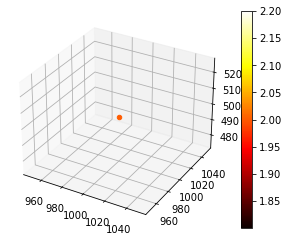

In [42]:
#We display our coordinates

josh = scalarlist

if dim==2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = plot_list[0]
    y = plot_list[1]
    z = josh
    img = ax.scatter(x, y, z)
    plt.xlabel('x - axis')
    # frequency label
    plt.ylabel('y - axis')
    # plot title
    plt.title('My scatter plot!')   

elif dim==3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = plot_list[0]
    y = plot_list[1]
    z = plot_list[2]
    img = ax.scatter(x, y, z)
    plt.show()
elif dim==4:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = plot_list[0]
    y = plot_list[1]
    z = plot_list[2]
    c = plot_list[3]
    
    img = ax.scatter(x, y, z, c=josh, cmap=plt.hot())
    fig.colorbar(img)
    plt.show()